<a href="https://colab.research.google.com/github/GabrielaGuestory/MachineLearning/blob/main/Recomenda%C3%A7%C3%A3o_imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --quiet numpy
!pip install --upgrade --quiet torch torchvision pillow faiss-cpu
print("✅ Pacotes instalados com sucesso (CPU).")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 73.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.3 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.3 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.3 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.3 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.3 which is incompatible.


In [2]:
import faiss
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob


In [3]:
# Transformações para pré-processar imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Modelo ResNet18 pré-treinado (sem a camada final)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

def extract_features(img_path):
    """Extrai embedding da imagem usando ResNet18"""
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        feat = model(img_t).squeeze().numpy()
    return feat.astype("float32")

def show_image(path, title=""):
    """Mostra imagem"""
    img = Image.open(path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 95.4MB/s]


In [10]:
# Carregar imagens de vários formatos
image_paths = glob.glob("images/*.*")  # aceita .jpg, .png, etc.
print(f"🔹 {len(image_paths)} imagens carregadas.")

# Extrair embeddings de todas as imagens
features = []
for p in image_paths:
    try:
        feat = extract_features(p)
        features.append(feat)
    except Exception as e:
        print(f"⚠️ Erro ao processar {p}: {e}")

features = np.array(features, dtype="float32")

print("✅ Embeddings extraídos:", features.shape)



🔹 5 imagens carregadas.
✅ Embeddings extraídos: (5, 512)


In [15]:
from google.colab import files
import os
import zipfile

# Faz upload de um .zip com a pasta "images"
uploaded = files.upload()

# Extrai o zip no Colab
with zipfile.ZipFile("images.zip", "r") as zip_ref:
    zip_ref.extractall(".")

print("✅ Pasta 'images' carregada!")
print("Arquivos dentro da pasta:", os.listdir("images")[:5])


Saving images.zip to images (2).zip
✅ Pasta 'images' carregada!
Arquivos dentro da pasta: ['mesa retangular.jpg', 'microondas.jpg', 'cadeira de escritorio.jpg', 'anel solitario.jpg', 'panela eletrica.jpg']


In [16]:
print("Formato de features:", features.shape)
print("Número de imagens:", len(image_paths))
print("Primeiros caminhos:", image_paths[:5])


Formato de features: (5, 512)
Número de imagens: 5
Primeiros caminhos: ['images/mesa retangular.jpg', 'images/microondas.jpg', 'images/cadeira de escritorio.jpg', 'images/anel solitario.jpg', 'images/panela eletrica.jpg']


In [17]:
d = features.shape[1]  # dimensão dos vetores
index = faiss.IndexFlatL2(d)  # índice de distância Euclidiana
index.add(features)
print("✅ Index criado com", index.ntotal, "imagens.")


✅ Index criado com 5 imagens.


🔎 Resultados da busca para:


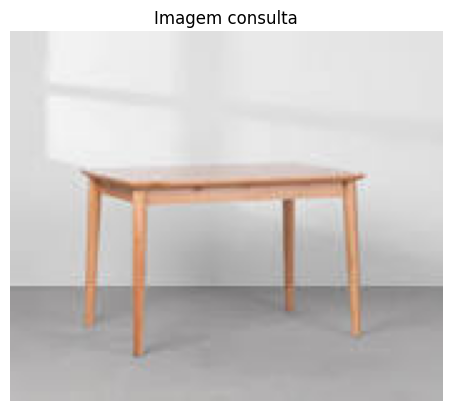

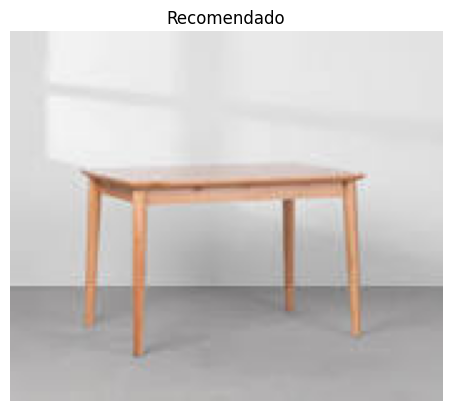

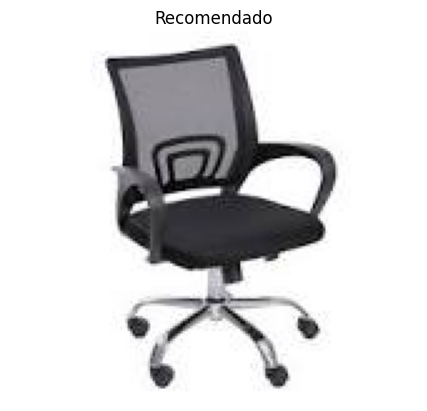

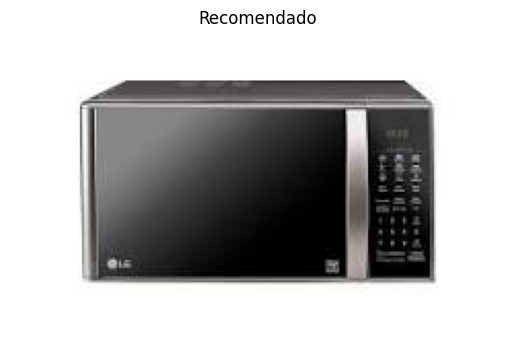

In [18]:
# Usar a primeira imagem como consulta
query_path = image_paths[0]
query_feat = extract_features(query_path).reshape(1, -1)

# Buscar top-3 similares
D, I = index.search(query_feat, 3)

print("🔎 Resultados da busca para:")
show_image(query_path, title="Imagem consulta")

for idx in I[0]:
    show_image(image_paths[idx], title="Recomendado")
